# Metadata

```
Course:   DS 5001
Module:   13 Lab
Topic:    Classification with SKLearn's Naive Bayes Classifier.
Author:   R.C. Alvarado
```

# Set Up

In [1]:
data_home = '../data'
data_prefix = 'winereviews'

In [117]:
import pandas as pd
import numpy as np
import plotly_express as px
from sklearn.naive_bayes import CategoricalNB, BernoulliNB

# Get Data

In [3]:
DOCS = pd.read_csv(f"{data_home}/{data_prefix}/{data_prefix}-NB_DOCS.csv").set_index(['doc_id'])
X_TRAIN = pd.read_csv(f"{data_home}/{data_prefix}/{data_prefix}-NB_TRAIN.csv").set_index(['doc_id'])
X_TEST = pd.read_csv(f"{data_home}/{data_prefix}/{data_prefix}-NB_TEST.csv").set_index(['doc_id'])

# Prepare X and y

In [4]:
y_TRAIN = X_TRAIN.join(DOCS.doc_label).doc_label
y_TEST = X_TEST.join(DOCS.doc_label).doc_label

In [5]:
y_TRAIN.sample(5)

doc_id
23196     P
45413     N
6354      P
19505     N
124308    P
Name: doc_label, dtype: object

In [6]:
y_TEST.sample(5)

doc_id
121888    P
88182     P
90372     P
100451    N
115920    N
Name: doc_label, dtype: object

# Fit Model

In [7]:
# CategoricalNB?

In [116]:
clf = BernoulliNB()
clf.fit(X_TRAIN, y_TRAIN)

BernoulliNB()

In [76]:
clf.score(X_TRAIN, y_TRAIN) # The mean accuracy against 10% internal validation set

0.9937148166366071

# Test Model

In [102]:
predictions = clf.predict(X_TEST)

In [78]:
y_PREDICT = pd.Series(predictions, index=X_TEST.index)

In [79]:
y_PREDICT.sample(5)

doc_id
32214     N
16541     P
123673    N
41428     P
3835      P
dtype: object

In [80]:
RESULTS = pd.concat([y_TEST, y_PREDICT], axis=1, keys=['actual','prediction'])

In [81]:
RESULTS

,actual,prediction
doc_id,,
30,N,N
52,N,N
56,N,N
63,N,N
64,N,P
...,...,...
129669,P,P
129670,P,P
129672,P,P


In [82]:
RESULTS['result'] = RESULTS.actual == RESULTS.prediction
RESULTS['result_type'] = RESULTS.result.astype('str').str[0] + RESULTS.prediction

In [83]:
RESULTS.sample(10)

,actual,prediction,result,result_type
doc_id,,,,
92609,N,N,True,TN
15540,P,P,True,TP
94086,N,N,True,TN
45398,N,N,True,TN
13623,N,N,True,TN
6560,N,N,True,TN
61578,N,N,True,TN
10455,N,N,True,TN
53286,N,N,True,TN


# Evaluate

In [84]:
RESULTS.result.value_counts()

True     5840
False     231
Name: result, dtype: int64

In [85]:
RESULTS.result_type.value_counts()

TN    2972
TP    2868
FN     119
FP     112
Name: result_type, dtype: int64

In [86]:
RESULTS

,actual,prediction,result,result_type
doc_id,,,,
30,N,N,True,TN
52,N,N,True,TN
56,N,N,True,TN
63,N,N,True,TN
64,N,P,False,FP
...,...,...,...,...
129669,P,P,True,TP
129670,P,P,True,TP
129672,P,P,True,TP


## Confusion Matrix

In [87]:
CM = RESULTS.reset_index().groupby(['prediction','actual']).doc_id.count().unstack().fillna(0)

In [88]:
CM

actual,N,P
prediction,,
N,2972,119
P,112,2868


In [89]:
def show_results(M):
    
    R = M.groupby('result_type').result_type.count().T
    
    print(R)
    print()

    # TP:  hits
    # FP:  Type I errors; false alarms
    # TN:  correct rejections
    # FN:  Type  II errors; misses
    # ACC: Accuracy
    # TPR: True Positive Rate, Recall, Sensitivity
    # TNR: True Negative Rate, Specificity
    # PPV: Positive Predictive Value, Precision
    # BA:  Balanced Accuracy
    # F1:  F-score where F = 1

    T = R.TP + R.TN
    F = R.FP + R.FN
    ALL =  T + F

    ACC = T / ALL
    TPR = R.TP / (R.TP + R.FN)
    TNR = R.TN / (R.TN + R.FP)
    PPV = R.TP / (R.TP + R.FP)
    BA = (TNR + TPR) / 2
    F1 = (2 *  R.TP) / (2 * R.TP + R.FP + R.FN)

    assert ALL == R.sum()

    print('TPR:', round(TPR, 2), '(sensitivity)')
    print('TNR:', round(TNR, 2), '(specificity)')
    print('F1: ', round(F1, 2), '<-- GRADE')
    print('PPV:', round(PPV, 2),  '(precision)')
    print('ACC:', round(ACC, 2), '(accuracy)')        

In [90]:
show_results(RESULTS)

result_type
FN     119
FP     112
TN    2972
TP    2868
Name: result_type, dtype: int64

TPR: 0.96 (sensitivity)
TNR: 0.96 (specificity)
F1:  0.96 <-- GRADE
PPV: 0.96 (precision)
ACC: 0.96 (accuracy)


# Explore

In [65]:
LIKELIHOODS = pd.DataFrame(clf.feature_log_prob_, index=clf.classes_, columns=clf.feature_names_in_).T
LIKELIHOODS.index.name = 'term_str'

In [66]:
SALEX = (np.sign(LIKELIHOODS['P'] - LIKELIHOODS['N'])).to_frame('polarity')
SALEX['valence'] = (LIKELIHOODS['P'] - LIKELIHOODS['N'])

In [67]:
SALEX.describe()

,polarity,valence
count,3576.000000,3576.000000
mean,0.407159,0.618972
std,0.913485,1.441983
min,-1.000000,-4.930582
25%,-1.000000,-0.166761
50%,1.000000,0.682547
75%,1.000000,1.543947
max,1.000000,5.741972


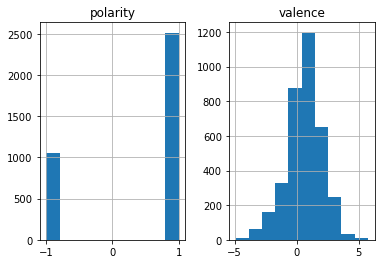

In [68]:
SALEX.hist();

## Top Positive Words

In [69]:
SALEX.sort_values('valence', ascending=False).head(20)

,polarity,valence
term_str,,
2025,1.0,5.741972
2030,1.0,5.576648
2023,1.0,5.312409
2022,1.0,5.045645
decade,1.0,4.993346
gorgeous,1.0,4.927464
2021,1.0,4.833586
94,1.0,4.725598
2026,1.0,4.652838


## Top negative words

In [70]:
SALEX.sort_values('valence', ascending=True).head(20)

,polarity,valence
term_str,,
everyday,-1.0,-4.930582
easygoing,-1.0,-4.798092
informal,-1.0,-4.328089
watery,-1.0,-4.259096
dilute,-1.0,-4.215293
bland,-1.0,-4.169484
scratchy,-1.0,-4.153735
simple,-1.0,-4.094636
pickled,-1.0,-4.017934


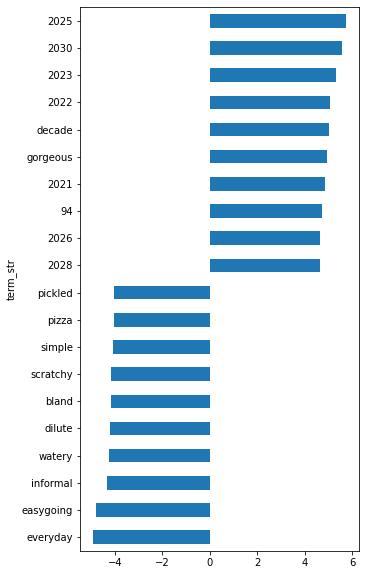

In [71]:
wpos = SALEX.valence.sort_values(ascending=False).head(10)
wneg = SALEX.valence.sort_values(ascending=True).head(10)
pd.concat([wpos,wneg]).sort_values().plot.barh(figsize=(5,10));

# Save

In [57]:
SALEX.to_csv(f'{data_home}/{data_prefix}/{data_prefix}-NB_SK_SALEX.csv')
RESULTS.to_csv(f'{data_home}/{data_prefix}/{data_prefix}-NB_SK_RESULTS.csv')